# 4998 Applied Deep Learning Project
## Detect Cancer Metastases on Pathology Images

Jing Qian (jq2282)

# STEP 1. IMAGE PROCESSING

* Read this paper to understand their approach https://arxiv.org/pdf/1703.02442.pdf
* Start small (use a single slide, at the lowest available zoom level - the effective resolution should be on the order of 1,000 by 1,000 pixels).
* Write code to slide a window across the slide. Extract patches and labels (using the tissue mask).

## 1.1. Import data

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# list all the slides provided by professor
!ls '/content/drive/My Drive/slides'

 tumor_001_mask.tif   tumor_031.xml	   tumor_081.tif
 tumor_001.tif	      tumor_035_mask.tif   tumor_081.xml
 tumor_001.xml	      tumor_035.tif	   tumor_084_mask.tif
 tumor_002_mask.tif   tumor_035.xml	   tumor_084.tif
 tumor_002.tif	     'tumor_038 (1).xml'   tumor_084.xml
 tumor_002.xml	      tumor_038.tif	   tumor_091_mask.tif
 tumor_005_mask.tif   tumor_038.xml	   tumor_091.tif
 tumor_005.tif	      tumor_057_mask.tif   tumor_091.xml
 tumor_005.xml	      tumor_057.tif	   tumor_094_mask.tif
 tumor_012_mask.tif   tumor_057.xml	   tumor_094.tif
 tumor_012.tif	      tumor_059_mask.tif   tumor_094.xml
 tumor_012.xml	      tumor_059.tif	   tumor_096_mask.tif
 tumor_016_mask.tif   tumor_059.xml	   tumor_096.tif
 tumor_016.tif	      tumor_064_mask.tif   tumor_096.xml
 tumor_016.xml	      tumor_064.tif	   tumor_099.xml
 tumor_019_mask.tif   tumor_064.xml	   tumor_101_mask.tif
 tumor_019.tif	      tumor_075_mask.tif   tumor_101.tif
 tumor_019.xml	      tumor_075.tif	   tumor_101.xml
 tumor_02

从上面可以看到完整的图像有21个，tumor_038和tumor_099有问题，不用。如果是全部都用于train/test，就17个train, 4个test。从1 vs 1开始

In [0]:
slides_list = ['001','002','005','012','016','019','023','031','035','057','059',
              '064','075','078','081','084','091','094','096','101','110']

## 1.2. Generate training patches and corresponding labels

### Start with one slide

###  General Params

In [0]:
input_size = 299
tumor_check_size = 128
ilevel = 4

In [0]:
total_path = '/content/drive/My Drive/project-adl/slides'

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

# This function has nothing to do with tumor mask, but shows tissue region
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [9]:
slide_id = '091'
slide_path = os.path.join(total_path,'tumor_%s.tif' %slide_id)
tumor_mask_path = os.path.join(total_path,'tumor_%s_mask.tif' %slide_id)

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/drive/My Drive/project-adl/slides/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /content/drive/My Drive/project-adl/slides/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# Example: read the entire slide at level 4

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=ilevel, 
                         width=slide.level_dimensions[ilevel][0], 
                         height=slide.level_dimensions[ilevel][1])

#plt.figure(figsize=(10,10), dpi=100)
#plt.imshow(slide_image)

In [11]:
# Keep only tissue regions
tissue_pixels = list(find_tissue_pixels(slide_image))
print('Dimension of Tissue_pixels:', np.shape(tissue_pixels))
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

#tissue_regions = apply_mask(slide_image, tissue_pixels)
#plt.imshow(tissue_regions)
#plt.imshow(mask_image,alpha=0.5)

Dimension of Tissue_pixels: (3451212, 2)
3451212 tissue_pixels pixels (30.6 percent of the image)


In [12]:
xmin, xmax, ymin, ymax = 0, 0, 0, 0
for i in tissue_pixels:
  xmin = min(i[0], xmin) #x correspond to dimention[
  xmax = max(i[0], xmax)
  ymin = min(i[1], ymin)
  ymax = max(i[1], ymax)
  
print(xmin, xmax, ymin, ymax)
print('canvas size:', slide.level_dimensions[ilevel])

0 3359 0 3839
canvas size: (3840, 3360)


In [0]:
bound = (input_size - 1)/2
nclass = 10
train_0, train_1 = [], []

In [65]:
while len(train_0) < nclass or len(train_1) < nclass:
  # Random sample a tissue pixel and generate a patch centered in this pixel
  while True:
    center = tissue_pixels[np.random.choice(np.shape(tissue_pixels)[0])]
    if center[0] >= bound and center[0] <= slide.level_dimensions[ilevel][1]-bound:
      if center[1] >= bound and center[1] <= slide.level_dimensions[ilevel][0]-bound:
        break
  print(center)

  # Expand a 299*299 patch around the center tissue
  ipatch = read_slide(slide, 
                     x=int(center[0]-bound), 
                     y=int(center[1]-bound), 
                     level=ilevel, 
                     width=input_size, 
                     height=input_size)

  # Check whether the 128*128 center pixels have tumor
  ipixels = read_slide(tumor_mask,
                       x = center[0]*16-tumor_check_size//2, #need to change 16 for other levels
                       y = center[1]*16-tumor_check_size//2,
                       level = ilevel,
                       width = tumor_check_size,
                       height = tumor_check_size)[:,:,0]
  #plt.imshow(ipixels)

  ilabel = 0
  if np.any(ipixels) == 1:
    ilabel = 1
  print('The label for the patch is:', str(ilabel))
  if ilabel == 0:
    if len(train_0) < nclass:
      train_0.append(ipatch)
      print('train_0 add one patch and current have %d patches!' %len(train_0))
  else:
    if len(train_1) < nclass:
      train_1.append(ipatch)
      print('train_1 add one patch and current have %d patches!' %len(train_1))

(991, 2022)
The label for the patch is: 0
train_0 add one patch and current have 1 patches!
(1225, 1451)
The label for the patch is: 0
train_0 add one patch and current have 2 patches!
(1606, 1265)
The label for the patch is: 0
train_0 add one patch and current have 3 patches!
(1875, 2918)
The label for the patch is: 0
train_0 add one patch and current have 4 patches!
(813, 1621)
The label for the patch is: 0
train_0 add one patch and current have 5 patches!
(1387, 3191)
The label for the patch is: 0
train_0 add one patch and current have 6 patches!
(1001, 1239)
The label for the patch is: 0
train_0 add one patch and current have 7 patches!
(2813, 2667)
The label for the patch is: 0
train_0 add one patch and current have 8 patches!
(1701, 1382)
The label for the patch is: 0
train_0 add one patch and current have 9 patches!
(983, 1393)
The label for the patch is: 0
train_0 add one patch and current have 10 patches!
(2021, 1223)
The label for the patch is: 0
(698, 2520)
The label for the

## 1.3 Save training patches and images on Google Drive

In [0]:
import shutil
train_dir = 'drive/My Drive/project-adl/train'
if not os.path.exists(train_dir):
  os.mkdir(train_dir)
train_0_dir = os.path.join(train_dir, 'patches0')
train_1_dir = os.path.join(train_dir, 'patches1')
if not os.path.exists(train_0_dir):
  os.mkdir(train_0_dir)
if not os.path.exists(train_1_dir):
  os.mkdir(train_1_dir)

(10, 299, 299, 3)


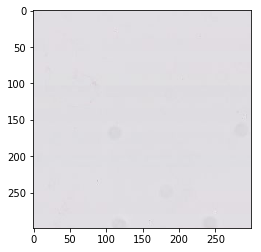

In [86]:
print(np.shape(train_1))
#plt.figure(figsize=(10,10),dpi=100)
plt.imshow(train_1[5])
from matplotlib.image import imsave
for i in range(len(train_0)):
  filename = os.path.join(train_0_dir,'tumor_%s_%d.png' %(slide_id, i))
  imsave(filename,train_0[1])
  
for i in range(len(train_1)):
  filename = os.path.join(train_1_dir,'tumor_%s_%d.png' %(slide_id, i))
  imsave(filename,train_1[1])

# STEP 2. MODELING

* Although transfer learning may be less effective than training a model from scratch , it is the best place to start.
* Choose a model previously trained on Imagenet. Use the techniques in Chapter 5 of Francois’s book to try transfer learning (add a single Dense layer on top of that model), and train it on your own data.
* Write a script that takes your trained model and a testing image, and outputs a heat map showing the cancerous regions.
* Design an evaluation metric, write a script to report your results

加快速度，不看背景，只看tissue。比如对色彩做个threshold

选一个特别放大的开始做，比如800\*600 pixel图片
annotation. 选择哪部分有cancer

image segmentation, 


In [0]:
TARGET_SHAPE = 299
BATCH_SIZE = 32

In [0]:
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

conv_base = InceptionV3(weights='imagenet',include_top=False, input_shape=(299,299,3))
#conv_base.summary()
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048)) # get from conv_base.summary()
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)       
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, nclass*2)
print(train_labels)

FLATTENED_SHAPE = 8 * 8 * 2048


In [91]:
train_features = np.reshape(train_features, (nclass*2, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history3 = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
20/20 [==============================] - 1s 68ms/sample - loss: 0.9534 - acc: 0.4500
Epoch 2/50
20/20 [==============================] - 0s 2ms/sample - loss: 2.5767 - acc: 0.7500
Epoch 3/50
20/20 [==============================] - 0s 2ms/sample - loss: 1.0960e-07 - acc: 1.0000
Epoch 4/50
20/20 [==============================] - 0s 2ms/sample - loss: 0.1539 - acc: 0.9500
Epoch 5/50
20/20 [==============================] - 0s 2ms/sample - loss: 1.0960e-07 - acc: 1.0000
Epoch 6/50
20/20 [==============================] - 0s 2ms/sample - loss: 1.0960e-07 - acc: 1.0000
Epoch 7/50
20/20 [==============================] - 0s 2ms/sample - loss: 1.0960e-07 - acc: 1.0000
Epoch 8/50
20/20 [==============================] - 0s 2ms/sample - loss: 1.0960e-07 - acc: 1.0000
Epoch 9/50
20/20 [==============================] - 0s 2